# Baseline models for Rental Bike Count

- naive
- seasonal naive
- random walk
- random walk with drift
- 2 month ahead forecast

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(fpp2)
library(forecast)
library(DMwR)
library(Metrics)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth
Loading required package: lattice
Loading required package: grid

Attaching package: ‘DMwR’

The following object is masked from ‘package:fma’:

    sales


Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



In [2]:
options(repr.plot.width=8, repr.plot.height=4)

## 1. Data import

In [3]:
path <- '../data/bike/bike-sharing-processed.csv'
data <- read_csv(path)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  season = col_double(),
  yr = col_double(),
  mnth = col_double(),
  holiday = col_double(),
  weekday = col_double(),
  workingday = col_double(),
  weathersit = col_double(),
  temp = col_double(),
  atemp = col_double(),
  hum = col_double(),
  windspeed = col_double(),
  cnt = col_double(),
  HurricaneSandy = col_double()
)


In [4]:
head(data)
tail(data)
nrow(data)

date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600,0
2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606,0


date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
2012-12-26,1,1,12,0,3,1,3,0.243333,0.220333,0.823333,0.316546,441,1
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114,1
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095,1
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341,1
2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796,1
2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,2729,1


[1] 731

## 2. Convert to ts object

In [5]:
# define date range as per the data
date_range <- seq(as.Date('2011-01-01'), as.Date('2012-12-31'), by='day')

# no need to put the date column as it will generate as ts index
dayofyear <- as.numeric(format(date_range[1], '%j'))

bike_data <- ts(data[, 13], start=c(2011, dayofyear), frequency = 365)

In [6]:
head(bike_data)

Time Series:
Start = c(2011, 1) 
End = c(2011, 6) 
Frequency = 365 
      cnt
[1,]  985
[2,]  801
[3,] 1349
[4,] 1562
[5,] 1600
[6,] 1606

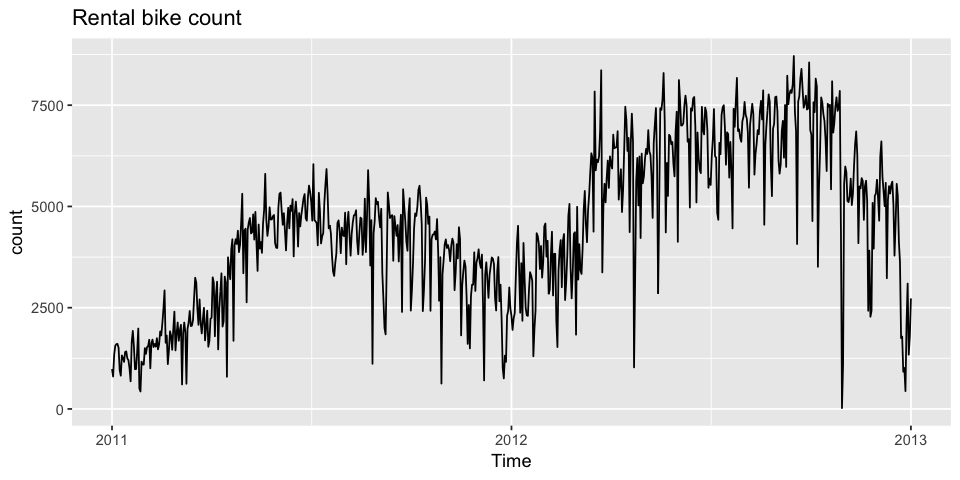

In [7]:
autoplot(bike_data) +
    ggtitle('Rental bike count') +
    ylab('count')

## 3. Train test split

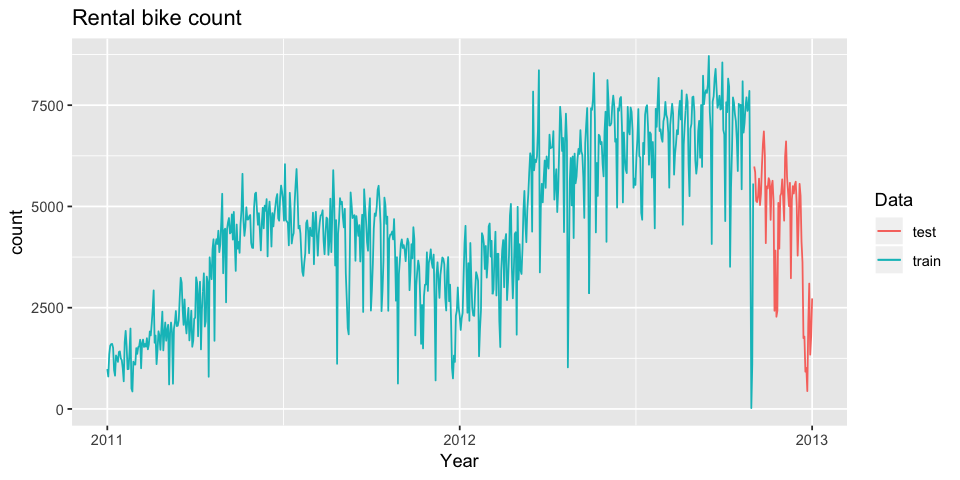

In [8]:
# train and test split
# last 2 month will be test set rest training set
# we will drop the explanatory  variables for baseline models
# as they will not be need for forecasting

test_size <- as.numeric(61)
train_size <- nrow(bike_data)- test_size

train <- head(bike_data, train_size)
test <- tail(bike_data, test_size)

autoplot(train, series = 'train') + 
    autolayer(test, series = 'test') +
    ggtitle('Rental bike count') +
    ylab('count') + 
    xlab('Year') +
    guides(colour=guide_legend(title="Data"))

In [9]:
head(train)

Time Series:
Start = c(2011, 1) 
End = c(2011, 6) 
Frequency = 365 
      cnt
[1,]  985
[2,]  801
[3,] 1349
[4,] 1562
[5,] 1600
[6,] 1606

In [10]:
tail(train)

Time Series:
Start = c(2012, 300) 
End = c(2012, 305) 
Frequency = 365 
      cnt
[1,] 7444
[2,] 7852
[3,] 4459
[4,]   22
[5,] 1096
[6,] 5566

In [11]:
head(test)

Time Series:
Start = c(2012, 306) 
End = c(2012, 311) 
Frequency = 365 
      cnt
[1,] 5986
[2,] 5847
[3,] 5138
[4,] 5107
[5,] 5259
[6,] 5686

## 4. Naive method forecasting

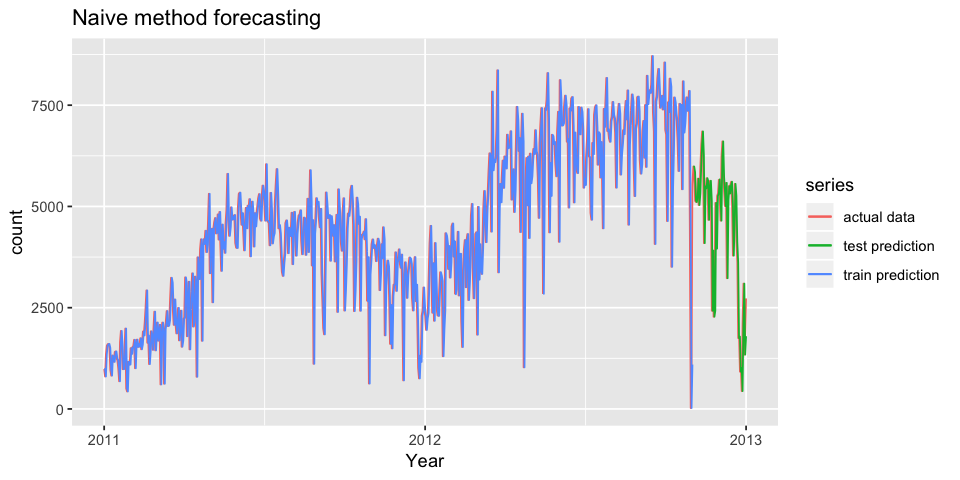

In [12]:
naive_model <- Arima(train, order = c(0, 1, 0))
naive_frcst <- Arima(test, model = naive_model)

autoplot(bike_data, series = 'actual data') +
    autolayer(fitted(naive_model), series = 'train prediction') +
    autolayer(fitted(naive_frcst), series = 'test prediction') +
    xlab('Year') +
    ylab('count') +
    ggtitle('Naive method forecasting')

In [13]:
train_pred <- fitted(naive_model)
test_pred <- fitted(naive_frcst)

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)

test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.542"
[1] "Training MAE :723.904"
[1] "Test NRMSE :0.648"
[1] "Test MAE :776.737"


## 5. Seasonal Naive Forecasting

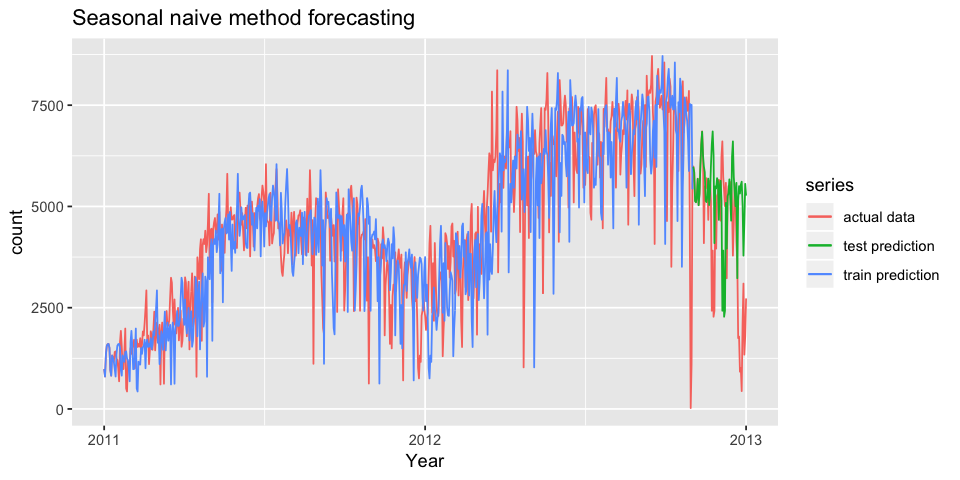

In [14]:
snaive_model <- Arima(train, order = c(0, 0, 0), seasonal = list(order = c(0, 1, 0), period=12))
snaive_frcst <- Arima(test, model = snaive_model)

autoplot(bike_data, series = 'actual data') +
    autolayer(fitted(snaive_model), series = 'train prediction') +
    autolayer(fitted(snaive_frcst), series = 'test prediction') +
    xlab('Year') +
    ylab('count') +
    ggtitle('Seasonal naive method forecasting')

In [15]:
train_pred <- fitted(snaive_model)
test_pred <- fitted(snaive_frcst)

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)

test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.661"
[1] "Training MAE :932.904"
[1] "Test NRMSE :1.244"
[1] "Test MAE :1338.017"


## 6. Random Walk with Drift

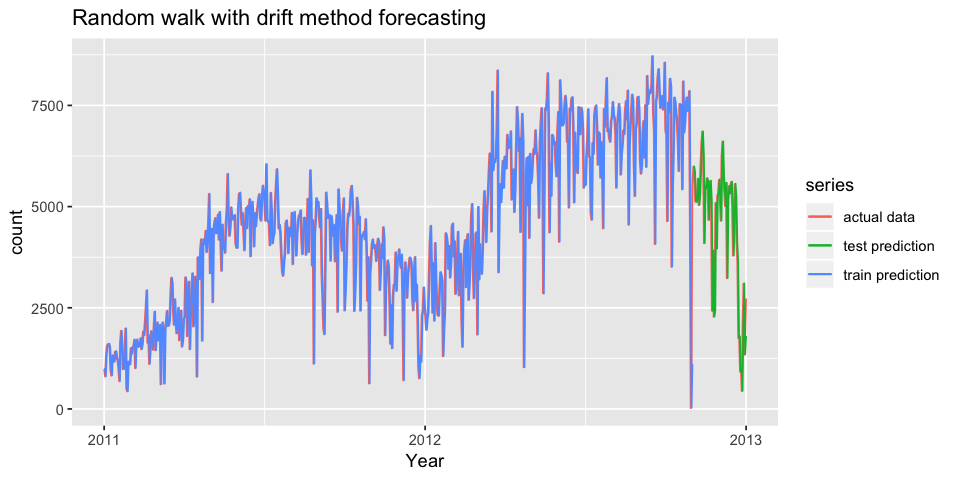

In [16]:
rwf_model <- Arima(train, order = c(0, 1, 0), include.drift = TRUE)
rwf_frcst <- Arima(test, model = rwf_model)

autoplot(bike_data, series = 'actual data') +
    autolayer(fitted(rwf_model), series = 'train prediction') +
    autolayer(fitted(rwf_frcst), series = 'test prediction') +
    xlab('Year') +
    ylab('count') +
    ggtitle('Random walk with drift method forecasting')

In [17]:
train_pred <- fitted(rwf_model)
test_pred <- fitted(rwf_frcst)

train_rmse <- sqrt(mse(train, train_pred))
train_mae <- mae(train, train_pred)
train_nrmse <- train_rmse/sd(train)

test_rmse <- sqrt(mse(test, test_pred))
test_mae <- mae(test, test_pred)
test_nrmse <- test_rmse/sd(test)

print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.542"
[1] "Training MAE :723.405"
[1] "Test NRMSE :0.648"
[1] "Test MAE :776.438"
